In [1]:
## Let's look at what they look like

## slide 03

import pickle
import gzip
import openslide
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib
import os 
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


with gzip.open("../../results/Ovarian/compute_patches/all/patches_info.pkl.gz", "rb") as f:
    patches_info = pickle.load(f)

labels = pd.read_csv("../../results/Ovarian/compute_patches/all/spots_labels.csv")




In [2]:
slide_id = '03'
save_path = "../../results/Ovarian/benchmark/uni_explora_models/invasive_cancer_clustering/kmeans/uni"
invasive_labels_filename = "invasive_labels_6_clusters_umap_min_dist_0.001_n_neighbors_300.csv"

save_name = invasive_labels_filename.split("labels_")[1].split('.csv')[0]


In [3]:
invasive_labels = pd.read_csv(os.path.join(save_path, invasive_labels_filename), index_col=0)


In [4]:
## Check if coordinates are correct for a spot

path_origin = [patch for patch in patches_info if patch["name_origin"] == f"NAB-HUG-{slide_id}_HE_Visium3_Scan1"][0]["path_origin"]


# Open the whole slide image
slide = openslide.OpenSlide(path_origin)
# Get a thumbnail for quick visualization
thumbnail = slide.get_thumbnail(slide.dimensions).convert("RGB")

img = np.array(thumbnail)


In [5]:
df_patches_info = pd.DataFrame(patches_info)
df_patches_info.set_index("name", inplace=True)


In [6]:
invasive_patches_info = invasive_labels.merge(df_patches_info, left_index=True, right_index=True, how='left')

In [7]:
invasive_patches_info["predicted_label"].value_counts().index

Int64Index([1, 0, 2, 4, 5, 3], dtype='int64')

In [8]:
palette={'0': '#F9A11B', '2': '#ACB5B6', '4': '#66BB46', '3': '#EC2A90', '1': '#31C4F3', '5': 'purple'}


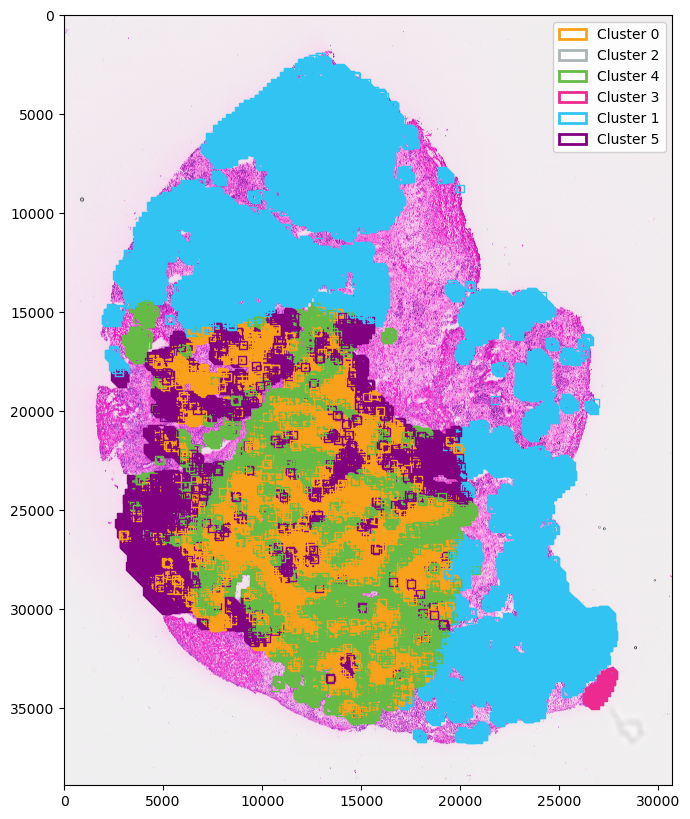

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.collections import PatchCollection

# Filter patches for the specific slide first
slide_patches = invasive_patches_info[invasive_patches_info["name_origin"] == f"NAB-HUG-{slide_id}_HE_Visium3_Scan1"]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(thumbnail)

# Create all rectangles and colors at once
rectangles = []
colors = []

for idx, patch in slide_patches.iterrows():
    rect = Rectangle((patch["start_width_origin"], patch["start_height_origin"]), 
                     patch["shape_pixel"], patch["shape_pixel"])
    rectangles.append(rect)
    colors.append(palette[str(patch["predicted_label"])])

# Add all patches as a collection (much faster than individual patches)
collection = PatchCollection(rectangles, facecolors='none', edgecolors=colors, linewidths=1)
ax.add_collection(collection)

# Create legend handles with unfilled boxes
legend_handles = [Patch(facecolor='none', edgecolor=color, label=f'Cluster {label}', linewidth=2) 
                  for label, color in palette.items()]

# Add legend to the plot
ax.legend(handles=legend_handles, loc='upper right', fontsize=10, framealpha=0.9)

plt.savefig(os.path.join(save_path, f"slide_{slide_id}_{save_name}.pdf"), bbox_inches='tight')
plt.show()